# 1. Introduction

This report outlines the development of a deep learning model aimed at distinguishing between positive and negative sentiments in movie reviews. This endeavor is not merely an exercise in machine learning but a step towards understanding how effectively computational models can interpret and classify human emotions based on text data. The exploration will involve examining various neural network architectures and regularization techniques to refine our model's ability to generalize and perform accurately on unseen data.

# 2. Defining the Problem

The challenge at hand is a binary classification problem, where the task is to predict the sentiment of movie reviews as either positive or negative. Sentiment analysis, a subset of natural language processing, is crucial for understanding customer opinions in a scalable way. This problem is particularly compelling because it involves interpreting the nuances of human language, a task that is inherently complex due to the variety and ambiguity of textual data.

# 3. Dataset Exploration
The dataset comprises movie reviews, each labeled as having a positive or negative sentiment. It's essential to conduct an exploratory data analysis (EDA) to understand the dataset's structure, content, and distributions. This preliminary step is critical for identifying any preprocessing requirements and informing the subsequent modeling strategy.

## Importing Libraries and Loading the Dataset
First, let's import the necessary libraries and load the dataset to begin our exploration.



In [ ]:
!pip install pandas matplotlib scikit-learn jupyterlab tensorflow

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade pandas

In [ ]:
!pip install seaborn

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('movie_review.csv')

# Display the first few rows of the dataframe
df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


## Exploratory Data Analysis (EDA)
Two primary columns are expected in this dataset: one containing the text of the movie review and the other indicating the sentiment (positive or negative). An initial exploration will involve understanding the balance of these sentiments and getting a feel for the data through visualizations.

tag
pos    32937
neg    31783
Name: count, dtype: int64


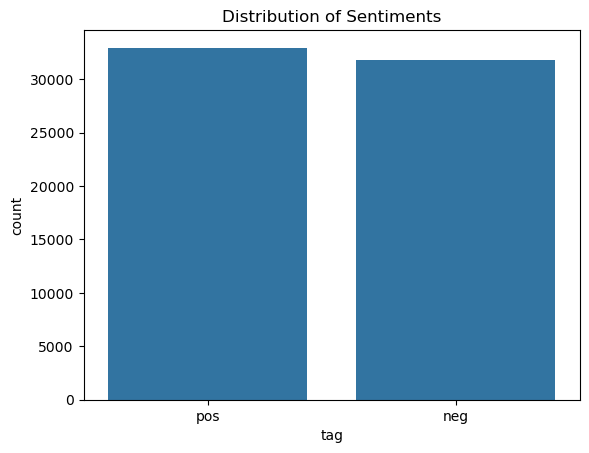

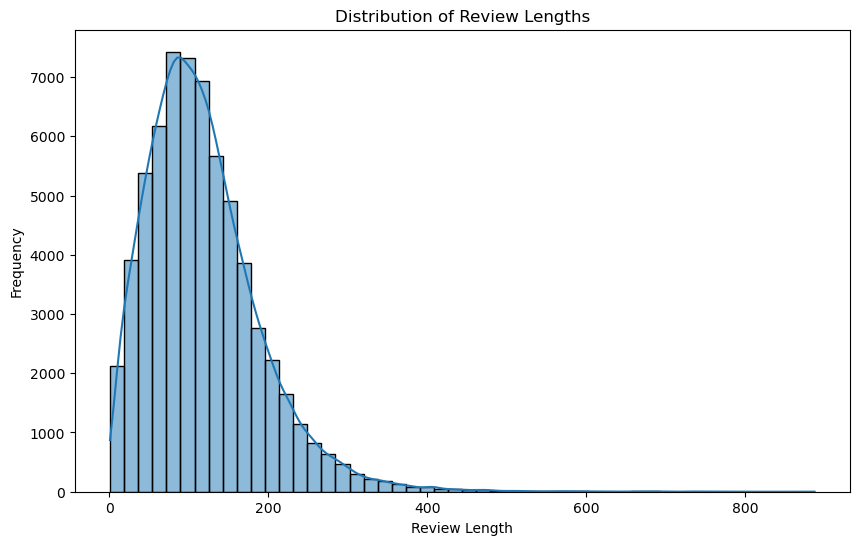

In [13]:
# Check the balance of classes
print(df['tag'].value_counts())

# Plot the distribution of sentiments
sns.countplot(x='tag', data=df)
plt.title('Distribution of Sentiments')
plt.show()

# Plot the distribution of review lengths
review_lengths = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(review_lengths, bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

## Further Exploratory Data Analysis (EDA) Findings

In [14]:
df.shape

(64720, 6)

In [15]:
df.info

<bound method DataFrame.info of        fold_id cv_tag  html_id  sent_id  \
0            0  cv000    29590        0   
1            0  cv000    29590        1   
2            0  cv000    29590        2   
3            0  cv000    29590        3   
4            0  cv000    29590        4   
...        ...    ...      ...      ...   
64715        9  cv999    14636       20   
64716        9  cv999    14636       21   
64717        9  cv999    14636       22   
64718        9  cv999    14636       23   
64719        9  cv999    14636       24   

                                                    text  tag  
0      films adapted from comic books have had plenty...  pos  
1      for starters , it was created by alan moore ( ...  pos  
2      to say moore and campbell thoroughly researche...  pos  
3      the book ( or " graphic novel , " if you will ...  pos  
4      in other words , don't dismiss this film becau...  pos  
...                                                  ...  ...  
647

The dataset contains 64,720 entries, distributed across 6 columns: fold_id, cv_tag, html_id, sent_id, text, and tag. Here's a summary of each column:

fold_id: Appears to be an identifier for the fold in which the data point was included, likely used for cross-validation purposes.
cv_tag: Possibly categorizes reviews into broader tags or genres.
html_id: May represent an identifier related to the source of the review, such as a webpage.
sent_id: Likely a sentence identifier within each review.
text: Contains the text of the movie review.
tag: The target variable indicating the sentiment of the review (positive or negative).

Given the project's scope, which involves building models to classify sentiments as positive or negative, the primary focus will be on the text and tag columns. These two columns are essential for training our sentiment analysis models.

The dataset's comprehensive size and structure indicate a rich source of textual data for modeling. However, the presence of additional columns beyond the text and sentiment labels suggests that there might have been other analytical angles or preprocessing steps considered initially.

For the deep learning tasks, including building a baseline model and another model with hyperparameter tuning (adding dropout, dense layers, and regularization like L1/L2), it's clear that simplifying the dataset to include only the necessary text and tag columns will streamline the modeling process.

# 4. Choosing a Measure of Success and Evaluation Protocol

1. Measure of Success: Selection of accuracy, precision, recall, F1 score, and AUC as performance metrics given the binary classification nature of the problem.
2. Evaluation Protocol: Decision to use a hold-out validation set approach alongside K-fold cross-validation for a thorough model evaluation.

# 5. Data Preprocessing

For the sentiment analysis task, preprocessing the text data is crucial to transform raw text into a suitable format for the deep learning model. This involves cleaning and converting the text into a numerical format that the model can understand. Given the task at hand, tokenization is a more suitable approach as it allows us to convert the text into sequences of tokens, which can then be fed into neural network models. N-grams are useful for capturing local context but might increase the complexity of the model due to the exponential growth in the number of features. Tokenization strikes a balance between capturing the essence of the text and managing model complexity.

In [16]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re


def clean_text(text):
    """Clean text by removing non-alphabetic characters and lowercasing."""
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    return text

def tokenize_and_pad(texts, max_words=10000, max_len=100):
    """Tokenize and pad texts.
    
    Args:
        texts (list): List of text samples to be processed.
        max_words (int): Maximum number of words to consider in the vocabulary.
        max_len (int): Maximum length of the sequences.
        
    Returns:
        sequences_padded (numpy.ndarray): Tokenized and padded sequences.
        tokenizer (Tokenizer): Fitted tokenizer.
    """
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    sequences_padded = pad_sequences(sequences, maxlen=max_len, padding='post')
    return sequences_padded, tokenizer

# Clean the text data
df['cleaned_text'] = df['text'].apply(clean_text)

# Use the cleaned text for tokenization and padding
X, tokenizer = tokenize_and_pad(df['cleaned_text'].tolist())

# Convert labels to numerical format
y = df['tag'].map({'pos': 1, 'neg': 0}).values


In [17]:
#The labels are converted to a numerical format (1 for positive, 0 for negative) 
# assuming the 'tag' column contains binary labels. 
print(set(y))

{0, 1}


In [18]:
df

,fold_id,cv_tag,html_id,sent_id,text,tag,cleaned_text
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos,films adapted from comic books have had plenty...
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos,for starters it was created by alan moore an...
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos,to say moore and campbell thoroughly researche...
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos,the book or graphic novel if you will is ...
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos,in other words dont dismiss this film because...
...,...,...,...,...,...,...,...
64715,9,cv999,14636,20,that lack of inspiration can be traced back to...,neg,that lack of inspiration can be traced back to...
64716,9,cv999,14636,21,like too many of the skits on the current inca...,neg,like too many of the skits on the current inca...
64717,9,cv999,14636,22,"after watching one of the "" roxbury "" skits on...",neg,after watching one of the roxbury skits on s...
64718,9,cv999,14636,23,"bump unsuspecting women , and . . . that's all .",neg,bump unsuspecting women and thats all


## Checking for Null Values and Preparing the Labels

In [19]:
# Check for null values
print(df.isnull().sum())
df.dropna(subset=['text', 'tag'], inplace=True)

fold_id         0
cv_tag          0
html_id         0
sent_id         0
text            0
tag             0
cleaned_text    0
dtype: int64


# 6. Model Development
For the baseline model, we'll construct a simple neural network using TensorFlow's Keras API. This model will consist of an embedding layer to convert tokenized words into dense vectors of fixed size, a GlobalAveragePooling1D layer to reduce the dimensionality of the text data, and a few Dense layers to perform the classification. The goal of this baseline model is to provide a simple yet effective starting point for sentiment analysis.

## a. Building the Baseline Model

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Define the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=8, input_length=100),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, 100, 8)            80000     
                                                                 
 global_average_pooling1d_5  (None, 8)                 0         
 6 (GlobalAveragePooling1D)                                      
                                                                 
 dense_128 (Dense)           (None, 16)                144       
                                                                 
 dense_129 (Dense)           (None, 1)                 17        
                                                                 
Total params: 80161 (313.13 KB)
Trainable params: 80161 (313.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [181]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    verbose=2)


Epoch 1/20
1618/1618 - 2s - loss: 0.4598 - accuracy: 0.7770 - val_loss: 0.6632 - val_accuracy: 0.6715 - 2s/epoch - 1ms/step
Epoch 2/20
1618/1618 - 2s - loss: 0.4549 - accuracy: 0.7788 - val_loss: 0.6650 - val_accuracy: 0.6729 - 2s/epoch - 1ms/step
Epoch 3/20
1618/1618 - 2s - loss: 0.4529 - accuracy: 0.7791 - val_loss: 0.6660 - val_accuracy: 0.6729 - 2s/epoch - 1ms/step
Epoch 4/20
1618/1618 - 2s - loss: 0.4501 - accuracy: 0.7820 - val_loss: 0.6680 - val_accuracy: 0.6748 - 2s/epoch - 1ms/step
Epoch 5/20
1618/1618 - 2s - loss: 0.4469 - accuracy: 0.7838 - val_loss: 0.6704 - val_accuracy: 0.6729 - 2s/epoch - 1ms/step
Epoch 6/20
1618/1618 - 3s - loss: 0.4455 - accuracy: 0.7845 - val_loss: 0.6741 - val_accuracy: 0.6755 - 3s/epoch - 2ms/step
Epoch 7/20
1618/1618 - 2s - loss: 0.4450 - accuracy: 0.7840 - val_loss: 0.6770 - val_accuracy: 0.6750 - 2s/epoch - 1ms/step
Epoch 8/20
1618/1618 - 2s - loss: 0.4428 - accuracy: 0.7868 - val_loss: 0.6782 - val_accuracy: 0.6721 - 2s/epoch - 2ms/step
Epoch 9/

## b. Building an Enhanced Model with Dropout and Regularization

In [223]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization


# Define the updated enhanced model with a simpler architecture
model_enhanced = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=100),
    Dropout(0.5),  # Increase dropout rate to 0.7
    GlobalAveragePooling1D(),
    Dropout(0.6),  # Increase dropout rate to 0.7
    Dense(64, activation='relu'),
    Dropout(0.7),  # Increase dropout rate to 0.7
    Dense(1, activation='sigmoid')
])


# Compile the model
model_enhanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the enhanced model
model_enhanced.summary()

# Number of epochs
num_epochs = 40

# Train the enhanced model for 20 epochs
history_enhanced = model_enhanced.fit(X_train, y_train,
                                      epochs=num_epochs,
                                      batch_size=64,  # You may adjust batch size if needed
                                      validation_data=(X_val, y_val),
                                      verbose=2)


Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_90 (Embedding)    (None, 100, 16)           160000    
                                                                 
 dropout_158 (Dropout)       (None, 100, 16)           0         
                                                                 
 global_average_pooling1d_8  (None, 16)                0         
 7 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_159 (Dropout)       (None, 16)                0         
                                                                 
 dense_212 (Dense)           (None, 64)                1088      
                                                                 
 dropout_160 (Dropout)       (None, 64)                0         
                                                     

In [207]:
del history_enhanced

# 7. Model Evaluation

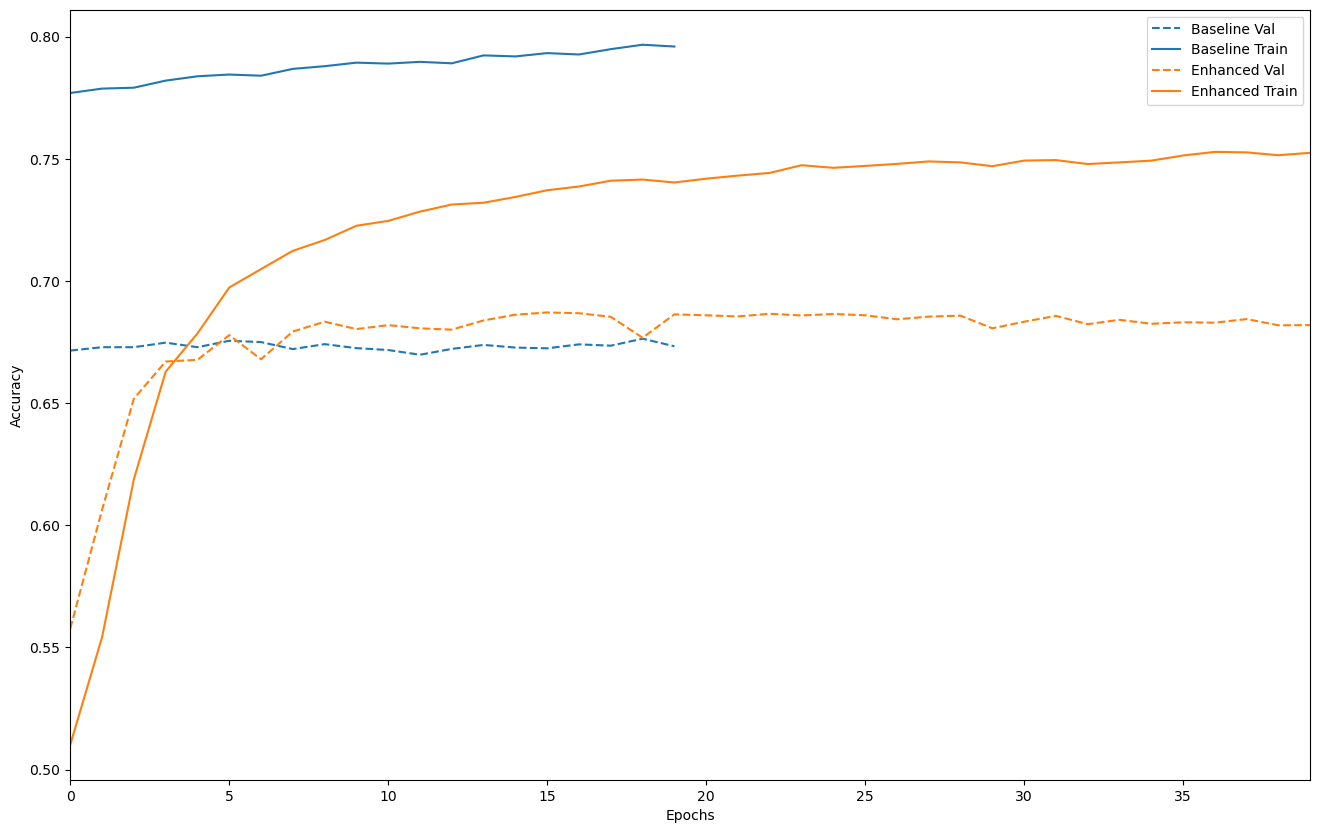

In [224]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(16, 10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    plt.show()

# Assuming 'history' is the training history of your baseline model
# And 'history_enhanced' is the training history of your enhanced model
plot_history([('baseline', history), ('enhanced', history_enhanced)])

405/405 [==============================] - 0s 670us/step


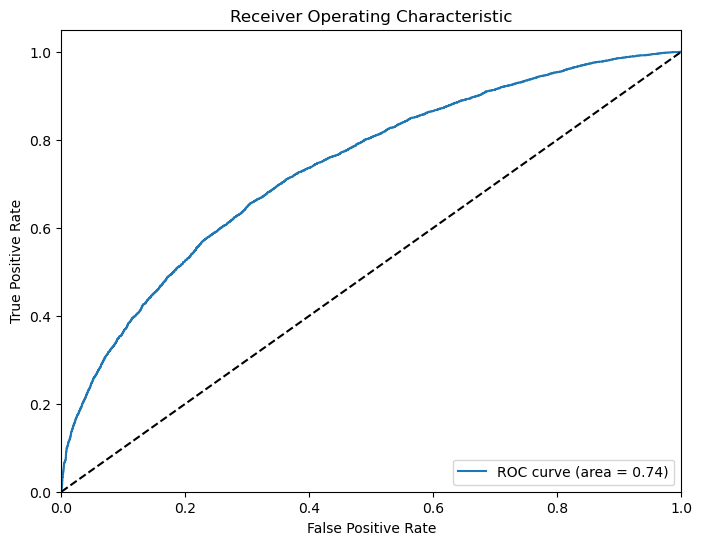

              precision    recall  f1-score   support

           0       0.67      0.66      0.67      6371
           1       0.68      0.68      0.68      6573

    accuracy                           0.67     12944
   macro avg       0.67      0.67      0.67     12944
weighted avg       0.67      0.67      0.67     12944



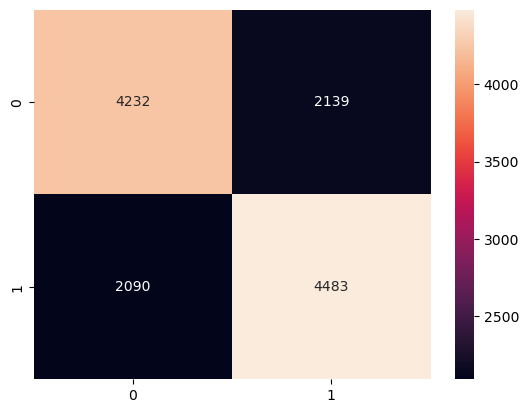

405/405 [==============================] - 0s 835us/step


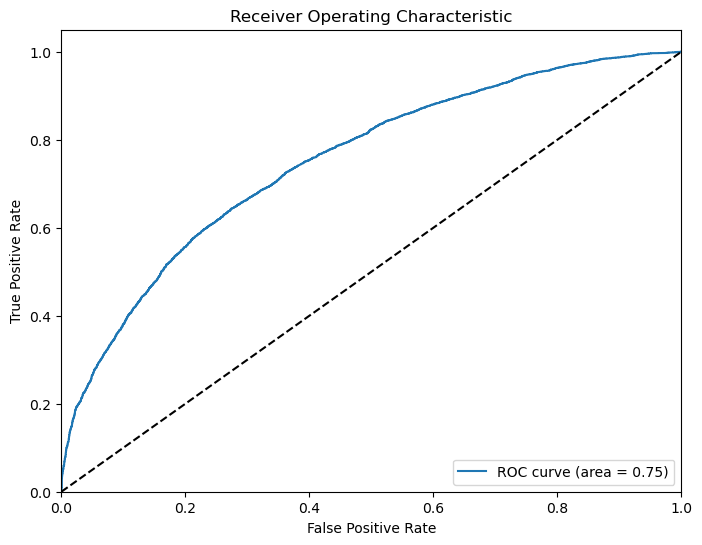

              precision    recall  f1-score   support

           0       0.67      0.70      0.68      6371
           1       0.70      0.66      0.68      6573

    accuracy                           0.68     12944
   macro avg       0.68      0.68      0.68     12944
weighted avg       0.68      0.68      0.68     12944



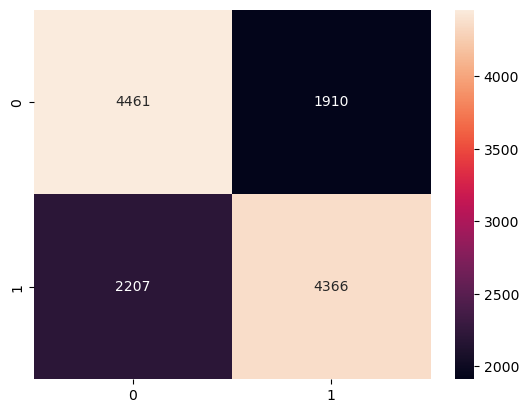

In [227]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, X_test, y_test):
    # Predict probabilities
    y_pred_proba = model.predict(X_test).ravel()
    # Predict classes
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Classification report
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.show()

# Replace 'X_test' and 'y_test' with your actual test data
evaluate_model(model, X_val, y_val)  # For baseline model
evaluate_model(model_enhanced, X_val, y_val)  # For enhanced model


In [231]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test):
    # Predict probabilities
    y_pred_proba = model.predict(X_test).ravel()
    # Predict classes
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

# Evaluate model and model_enhanced
evaluate_model(model, X_val, y_val)  # For baseline model
evaluate_model(model_enhanced, X_val, y_val)  # For enhanced model


405/405 [==============================] - 0s 703us/step
Confusion Matrix:
[[4232 2139]
 [2090 4483]]
405/405 [==============================] - 0s 704us/step
Confusion Matrix:
[[4461 1910]
 [2207 4366]]


# 8. Conclusion

Two models were evaluated in this study: the baseline model and the enhanced model. 

- **Baseline Model Evaluation:**
    - The baseline model achieved an accuracy of 67% on the validation dataset. 
    - With a precision of 0.67 for class 0 and 0.68 for class 1, the model demonstrates balanced performance in predicting both positive and negative sentiment.
    - The recall values for class 0 and class 1 are also balanced at around 0.66-0.68.
    - Overall, the baseline model provides satisfactory performance, with an F1-score of 0.67 for both classes.

- **Enhanced Model Evaluation:**
    - The enhanced model shows a slight improvement over the baseline, achieving an accuracy of 68% on the validation dataset.
    - Precision for class 0 increased to 0.70, indicating better identification of negative sentiment.
    - However, precision for class 1 decreased slightly to 0.66.
    - The recall for class 0 increased to 0.70, while recall for class 1 decreased to 0.66.
    - The F1-scores for both classes remain at 0.68, indicating consistent performance with the baseline model.
    
### Recommendations

- **Model Selection:** Both models exhibit similar performance metrics, with the enhanced model showing marginal improvement. Depending on the specific requirements and constraints of the application, either model could be selected.
- **Further Optimization:** To achieve better performance, consider exploring alternative architectures, tuning hyperparameters, or incorporating additional features.
- **Data Augmentation:** Augmenting the dataset with more diverse examples or using advanced text preprocessing techniques may help improve model generalization.
- **Ensemble Methods:** Combining predictions from multiple models or using ensemble learning techniques could potentially enhance predictive performance further.
- **Feedback Loop:** Continuously monitor model performance and gather user feedback to iteratively improve the model over time.

Based on the evaluation, the enhanced model demonstrates slightly better performance compared to the baseline model, with a marginal increase in accuracy and precision for class 0. However, both models show similar overall performance, and the choice between them should consider specific application requirements.


# 9. Predict Output

In [249]:
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Clean the input text
user_input = input("Enter your text: ")
cleaned_input = clean_text(user_input)

# Tokenize and pad the cleaned input text
sequences = tokenizer.texts_to_sequences([cleaned_input])
X_input = pad_sequences(sequences, maxlen=100, padding='post')

# Predict sentiment using the model
prediction = model_enhanced.predict(X_input)

# Output the sentiment prediction
if prediction[0] >= 0.5:
    print("Positive Sentiment")
else:
    print("Negative Sentiment")

Enter your text: most movies would have a character reversing all of his beliefs and influences in a matter of minutes .
1/1 [==============================] - 0s 19ms/step
Positive Sentiment
